# Chapter 1. Neural encoding I: Firing rates and spike statistics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.integrate import odeint
from spike_generator import *

plt.style.use('seaborn-whitegrid')

## Task 1
Generate spikes for 10 s (or longer if you want better statistics) using
a Poisson spike generator with a constant rate of 100 Hz, and record
their times of occurrence. Compute the coefficient of variation of the
interspike intervals, and the Fano factor for spike counts obtained
over counting intervals ranging from 1 to 100 ms. Plot the interspike
interval histogram.

In [7]:
spikes = HomogeneousPoissonEfficient(100, 10)
print('Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)')
print(fano(spikes)[0])

Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)
0.9683342572593364


In [3]:
m = HomogeneousPoisson(100, 100)
m2 = HomogeneousPoissonEfficient(100, 100)

#plt.vlines(m, 0, 1)
#plt.vlines(m2, 0, 1)
#plt.title('Spike Train', loc='left')

## ISI (interspike intervals) distribution (density)

<IPython.core.display.Javascript object>


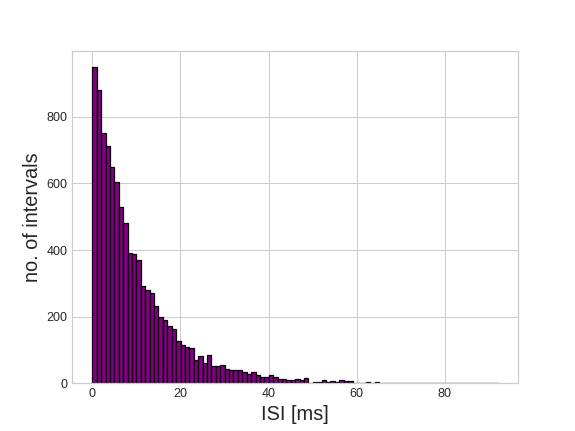

In [4]:
ISI_distribution( HomogeneousPoissonEfficient(100, 100) )

As can be seen, distribution is exponentially decaying, which makes sense, because the longer it has been since
last spike the more likely it will be fired soon. 
Due to the absense of refractoriness, distribution has the peak at 0. But in real neurons there is refractoriness
after firing the spike and, thus, no spike can be fired immediately after this event.

## Spike counts distribution
Firing rate 100 Hz

<IPython.core.display.Javascript object>


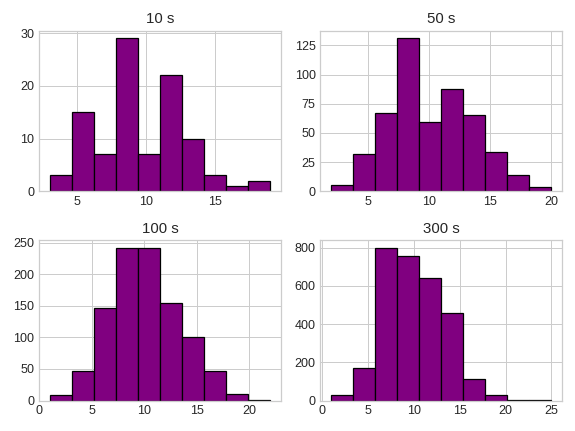

In [5]:
spikes = HomogeneousPoissonEfficient(100, 600)
distribution_spike_counts(spikes)

fig, axs = plt.subplots(2, 2)
fig.dpi=100
axs[0, 0].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 10)), color='purple', ec='black')
axs[0, 0].set_title('10 s')
axs[0, 1].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 50)), color='purple', ec='black' )
axs[0, 1].set_title('50 s')
axs[1, 0].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 100)), color='purple', ec='black' )
axs[1, 0].set_title('100 s')
axs[1, 1].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 300)), color='purple', ec='black' )
axs[1, 1].set_title('300 s')
plt.tight_layout()

As can be seen, for larger simulation times, distribution of counter spikes approaches normal distribution

## Compute the coefficient of variation ($C_V$) of ISI

In [6]:
isi = np.diff(m)
cv = coefficient_variation(isi)
print('Coefficient of variation: %s' % cv)

Coefficient of variation: 0.9484771134645107


## Compute the coefficient of variation ($C_V$) and fano factor for spike counts

In [7]:
cv = coefficient_variation(m)
print('Coefficient of variation: %s' % cv)

fano_factor = fano(m)
print('Fano factor: %s' % fano_factor[0])

Coefficient of variation: 0.572159066076243
Fano factor: 0.8993889327826061


## Task 2

Add a refractory period to the Poisson spike generator by allowing
the firing rate to depend on time. Initially, set the firing rate to a
constant value, $r(t) = r_0 $. After every spike, set $r(t)$ to 0, and then
allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$
that controls the refractory recovery rate. In other words, have $r(t)$
obey the equation

$$
\tau_{ref} \frac{dr}{dt} = r_0 - r
$$

except immediately after a spike, when it is set to 0.
Plot the coefficient of variation as a function of $\tau_{ref}$ over
the range $1 \ ms\ \le \tau_{ref} \le 20 \ ms$, and plot interspike interval histograms for a few values of $\tau_{ref}$ in this range.
Compute the Fano factor for spike counts obtaines over counting
intervals ranging from 1 to 100 ms for the case $\tau_{ref}=10 \ ms$

If we solve the above equaition, we will get:
$$
r(t) = r_0 - (r_0 - r_{init})\cdot \exp{\left(-\frac{t}{\tau_{ref}}\right)}
$$

<IPython.core.display.Javascript object>


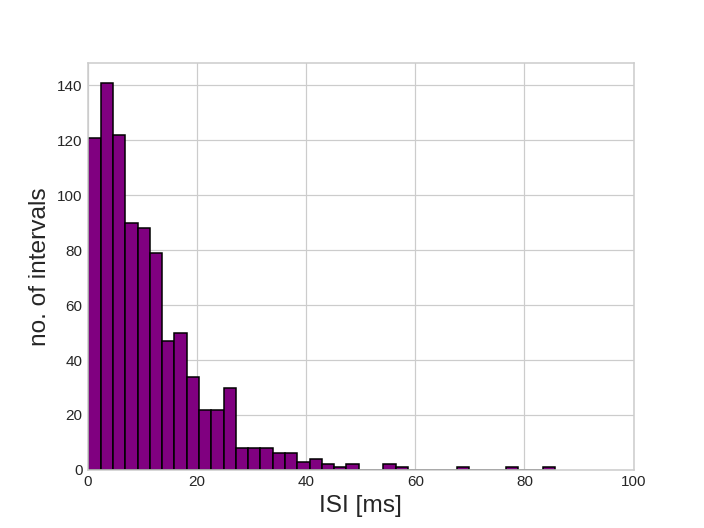

(0.0, 100.0)

In [60]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=1)
ISI_distribution(spikes_refrac)
plt.xlim(0, 100)

<IPython.core.display.Javascript object>


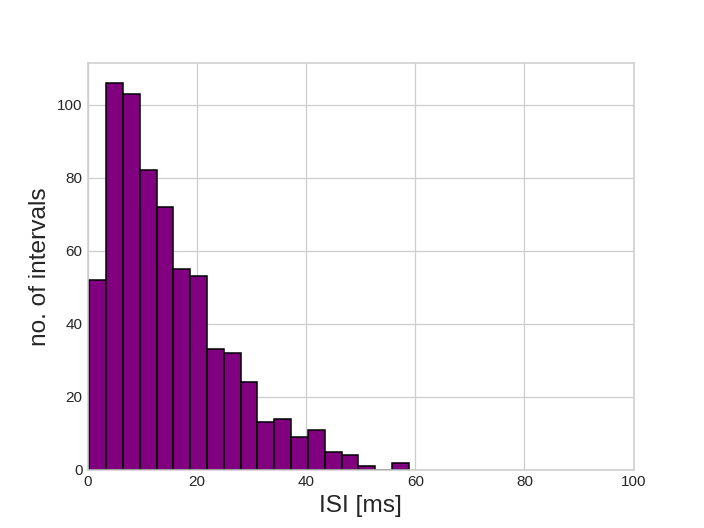

(0.0, 100.0)

In [61]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=5)
ISI_distribution(spikes_refrac)
plt.xlim(0, 100)

<IPython.core.display.Javascript object>


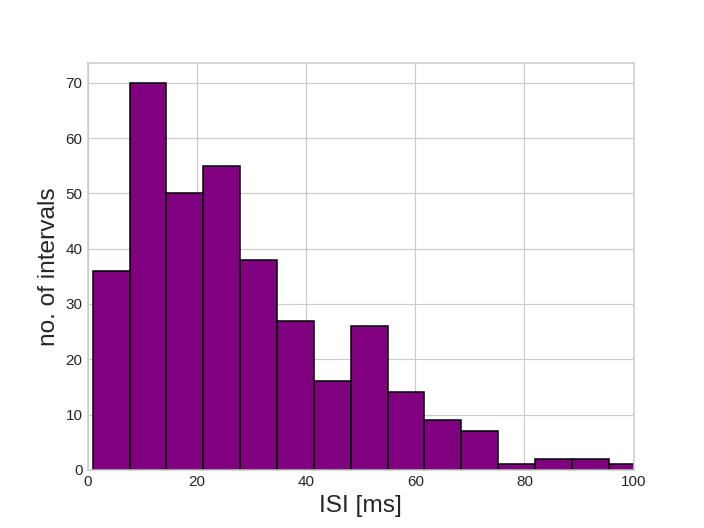

(0.0, 100.0)

In [62]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=20)
ISI_distribution(spikes_refrac)
plt.xlim(0, 100)

<IPython.core.display.Javascript object>


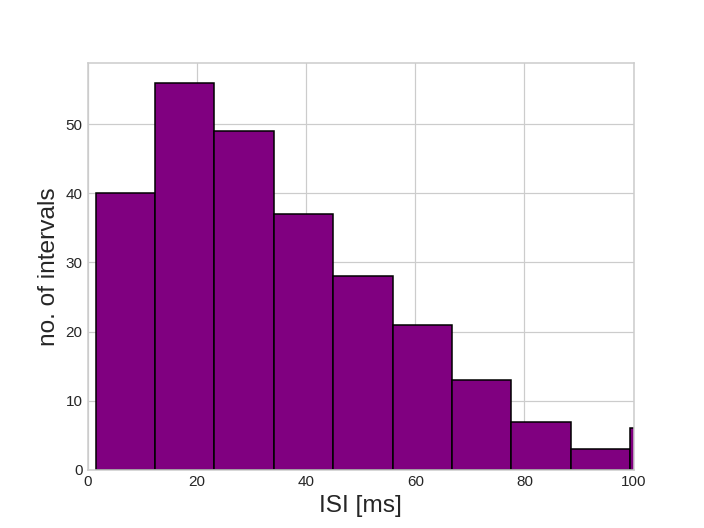

(0.0, 100.0)

In [63]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=30)
ISI_distribution(spikes_refrac);
plt.xlim(0, 100)

Plottting coefficient of variation ($C_V$) of ISI as a fucntion of $\tau_{ref}$

In [40]:
coeffs = []
for i in range(21, 1, -1):
    spikes = HomogeneousPoissonRefractory(100, 500, tau=i)
    isi = np.diff(spikes)
    coeffs.append(coefficient_variation(isi))
print(means)

[30.84563326787556, 29.790069302285563, 29.020932363326793, 28.247676555421453, 26.872995925298422, 25.746066607017248, 24.788340063257998, 23.84067626470414, 22.91192044593943, 21.997576069335043, 20.960826599697647, 20.057883220638637, 18.940471542141943, 18.0891364188684, 17.08178567248714, 15.936574111913762, 15.102510212296004, 14.074743620661398, 13.023732830352328, 11.943560718358981]


<IPython.core.display.Javascript object>


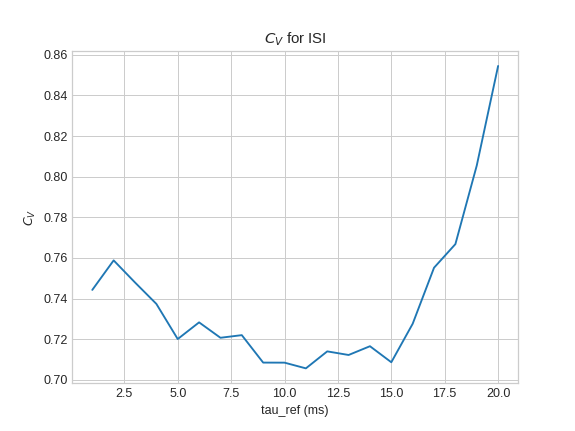

In [41]:
plt.figure()
plt.plot([i for i in range(1, 21) ] , coeffs)
plt.xlabel('tau_ref (ms)')
plt.ylabel('$C_V$')
plt.title('$C_V$ for ISI')
plt.show()

Plotting $C_V$ as a function of average ISI (different firing rates) with $\tau_{ref}$ = 10 ms

In [64]:
coeffs = []
for i in range(1, 100):
    spikes = HomogeneousPoissonRefractory(i, 1000, tau=2)
    isi = np.diff(spikes)
    coeffs.append(coefficient_variation(isi))

average_ISI = [ (1/i)*1000 for i in range(1, 100) ]

The **greater $\tau_{ref}$**, the longer we see less variance for different values of average ISI. Because for a longer period of time we have smaller probability of firing an action potential => variance decreases

<IPython.core.display.Javascript object>


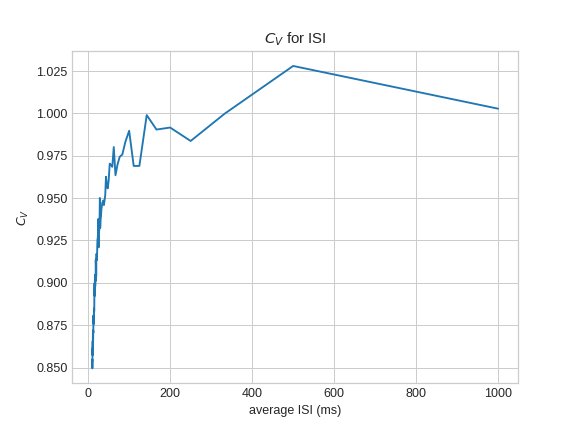

In [66]:
plt.figure()
plt.plot(average_ISI , coeffs)
plt.xlabel('average ISI (ms)')
plt.ylabel('$C_V$')
plt.title('$C_V$ for ISI')
plt.show()

Plottting coefficient of variation ($C_V$) of spike_counts as a fucntion of $\tau_{ref}$

In [13]:
coeffs = []
for i in range(1, 21):
    spikes = HomogeneousPoissonRefractory(100, 500, tau=i)
    coeffs.append(coefficient_variation(spike_count(spikes, step_interval=100)))

<IPython.core.display.Javascript object>


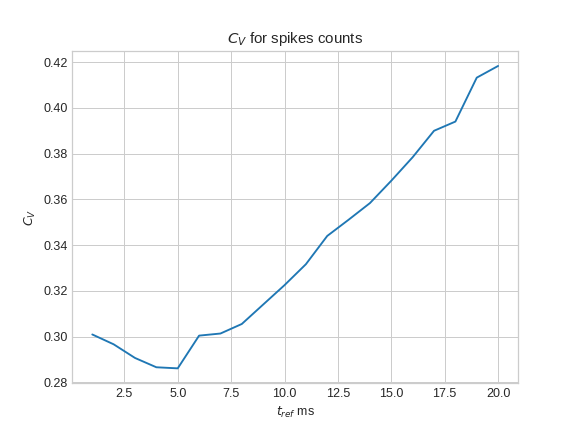

In [14]:
plt.figure()
plt.plot([i for i in range(1, 21)], coeffs)
plt.xlabel('$t_{ref}$ ms')
plt.ylabel('$C_V$')
plt.title('$C_V$ for spikes counts')
plt.show()

Computing Fano factors for spikes counts with step intervals [1, 100] ms

In [15]:
print( fano(HomogeneousPoissonRefractory(100, 10, tau=10)) )

[0.9514020556830656, 0.9315418444425315, 0.8829390500313541, 0.8671904650657617, 0.8350147753773767, 0.819266190411784, 0.7952021604340384, 0.7794001876258766, 0.7883165354011117, 0.768592179091509, 0.7241495118977048, 0.6796001426305499, 0.6673271287234327, 0.6679570942404618, 0.6693153733600561, 0.7394985272024719, 0.6947354476142001, 0.6990493847222016, 0.700131307739364, 0.676814748326755, 0.6689740377702876, 0.6688900421959969, 0.6566404682668932, 0.6452759763441812, 0.620282340862423, 0.6057014853729432, 0.5785019675996391, 0.5851575197980426, 0.6192066184566856, 0.6384254079110773, 0.6093031830694018, 0.6761223110784553, 0.5960246948719513, 0.6020828084320148, 0.586730517942017, 0.5952240261179146, 0.6197530864197531, 0.5924204728598476, 0.5542373971193416, 0.5920410677618071, 0.5811004140438281, 0.6452259916312204, 0.5813291501793411, 0.6121172567574916, 0.6009342676009344, 0.5792987047467335, 0.6314794998602153, 0.6346549540993985, 0.5106511740498669, 0.5567864476386036, 0.565

Plotting spike times

<IPython.core.display.Javascript object>


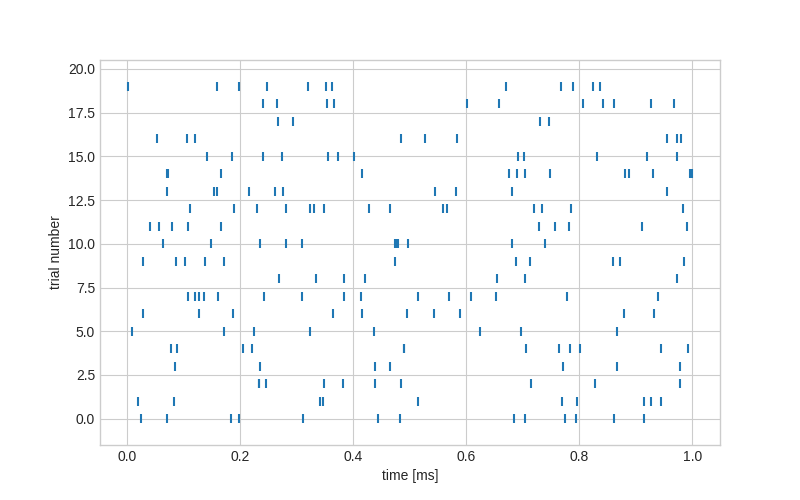

In [37]:
PlotTrials()

## Task 3
Compute autocorrelation histograms of spike trains generated by a Poisson generator with a
constant firing rate 100 Hz, a constant firing rate of 100 Hz together with a refractory period $\tau_{ref} = 10 \ ms$, and a variable firing rate:
$$
r(t) = 100\left(1 + \cos{\left(\frac{2\pi \cdot t}{25 \ ms}\right)}\right) \ Hz
$$
Plot the histograms over a range from 0 to 100 ms.


In [3]:
def rate_f(t):
    return 100*(1 + np.cos(2*np.pi*t*1000/25))


200.0


<IPython.core.display.Javascript object>


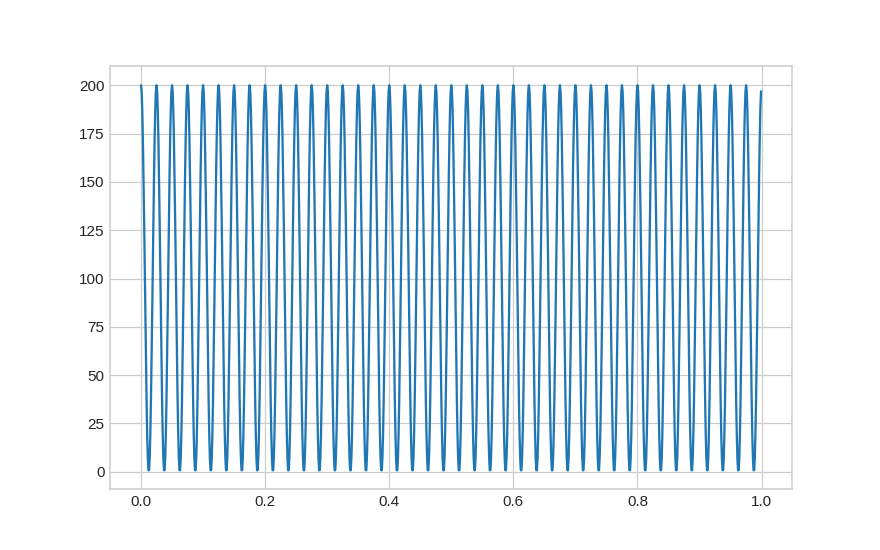

In [3]:
time = np.arange(0, 1, 0.001)
print(np.max( rate_f(time) ))
plt.figure(figsize=(8,5))
plt.plot(time, rate_f(time))

In [8]:
np.max(rate_func(time))

200.0

In [4]:
spikes1 = HomogeneousPoissonEfficient(200, 10)
locs1, freqs1 = autocorrelation(spikes1, time_lag=100, dt=1e-3)

spikes2 = HomogeneousPoissonRefractory(200, 10, tau=20)
locs2, freqs2 = autocorrelation(spikes2, time_lag=100, dt=1e-3)

spikes3 = NonhomogeneousPoisson(rate_func=rate_f, duration=10)
locs3, freqs3 = autocorrelation(spikes3, time_lag=100, dt=1e-3)

Building autocorrelation histograms for different parameters of simulation

<IPython.core.display.Javascript object>


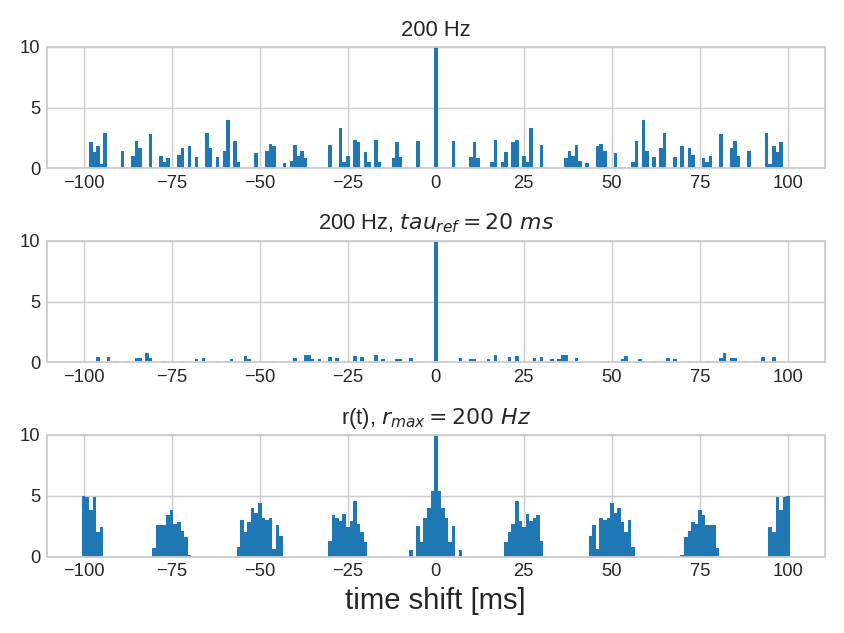

In [5]:
fig, axs = plt.subplots(3, 1)
fig.dpi=120

axs[0].bar(locs1, freqs1, width=1, bottom=0)
axs[0].set_ylim(0,10)
axs[0].set_title('200 Hz')

axs[1].bar(locs2, freqs2, width=1, bottom=0)
axs[1].set_ylim(0,10)
axs[1].set_title('200 Hz, $tau_{ref}=20 \ ms$')

axs[2].bar(locs3, freqs3, width=1, bottom=0)
axs[2].set_ylim(0,10)
axs[2].set_xlabel('time shift [ms]', fontsize=16)
axs[2].set_title('r(t), $r_{max} = 200 \ Hz$')

plt.tight_layout()
plt.show()

(I don't know how to check whether my autocorrelation works correctly. But the output seems reasonable)

As can be seen, when there is refractory period in a simualation, we have decreased values of the function the closee we to zero. Decrease in amplitude is proportional to the constant $\tau_{ref}$ In the bottom graph, we can see periodic structure in the autocorrelation histogram which is the indicator of oscillations in the firing rate

## Task 4
Generate a Poisson spike train with time-dependent firing rate $r(t) = 100(1 + \cos{(2\pi t/300  \ ms)}) \ Hz$. Approximate the firing rate from this spike train using a variable $r_{approx}$ that satisfies:
$$
\tau_{approx} \frac{dr_{approx}}{dt} = -r_{approx}
$$

except that $r_{approx} \rightarrow r_{approx} + 1/\tau_{approx}$ every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate.
Experiment with a few different values of $\tau_{approx}$ in the range of 1 to 100 ms. Determine the best value of $\tau_{approx}$ by computing the average squarred error of the estimate,
$$
\int{r(t)\cdot dt} - (r_{approx}(t))^2
$$
for different values of $\tau_{approx}$, and finding the value of $\tau_{approx}$ that minimizes the error.

If we solve the above differential equation, we will get:

$$
    r(t) = \frac{1}{\tau_{approx}}\exp{\left(-\frac{t}{\tau_{approx}}\right)}
$$

In [151]:
def NonhomogeneousPoissonRapprox(r_approx, duration, tau=10, dt=1e-4):
    '''
    Nonhomogeneous Poisson spike generator,
    after each spike firing rat is increased by 1/tau,
    and decays exponentially  exp(-t/tau)

    Return: array with spike times
    '''
    time = np.arange(0, 10, dt)
    r0 = 200 # convert tau to seconds
    spikes = [0]
    r_approx_vec = []
    for i in range(len(time)):
        r_a = r_approx(time[i] - spikes[-1], r0, tau_approx=tau)
        r_approx_vec.append(r_a)
        if  r_a * dt >= np.random.rand():
            spikes.append(time[i])
            r0 = r_a + 1000/tau
    return np.array(spikes), np.array(r_approx_vec)



In [171]:
def r(t):
    return 100 * (1 + np.cos(2*np.pi*t*1000/300)) # Hz

def r_approx(t, r0, tau_approx=10):
    return r0*np.exp(-t*1000/tau_approx)

spikes = NonhomogeneousPoisson(r, 10)
spikes2, r_approx_vec = NonhomogeneousPoissonRapprox(r_approx=r_approx,  duration=10, tau=50)

In [172]:
len(spikes2)
#print(r_approx_vec)

10950

<IPython.core.display.Javascript object>


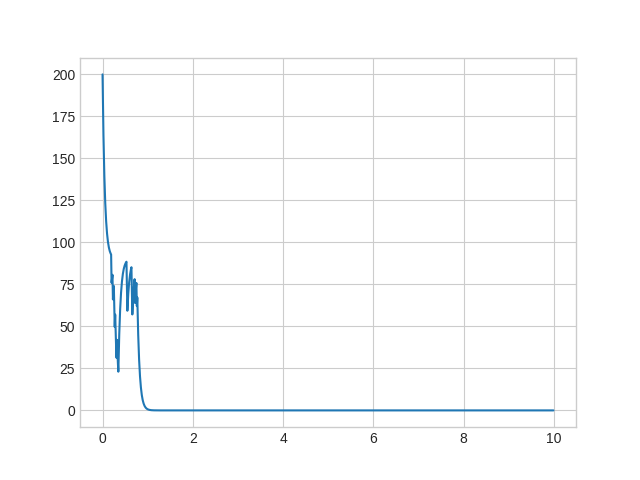

In [147]:
%matplotlib notebook
plt.figure()
time = np.arange(0, 10, 1e-2)
plt.plot(time, r_approx_vec)

<IPython.core.display.Javascript object>


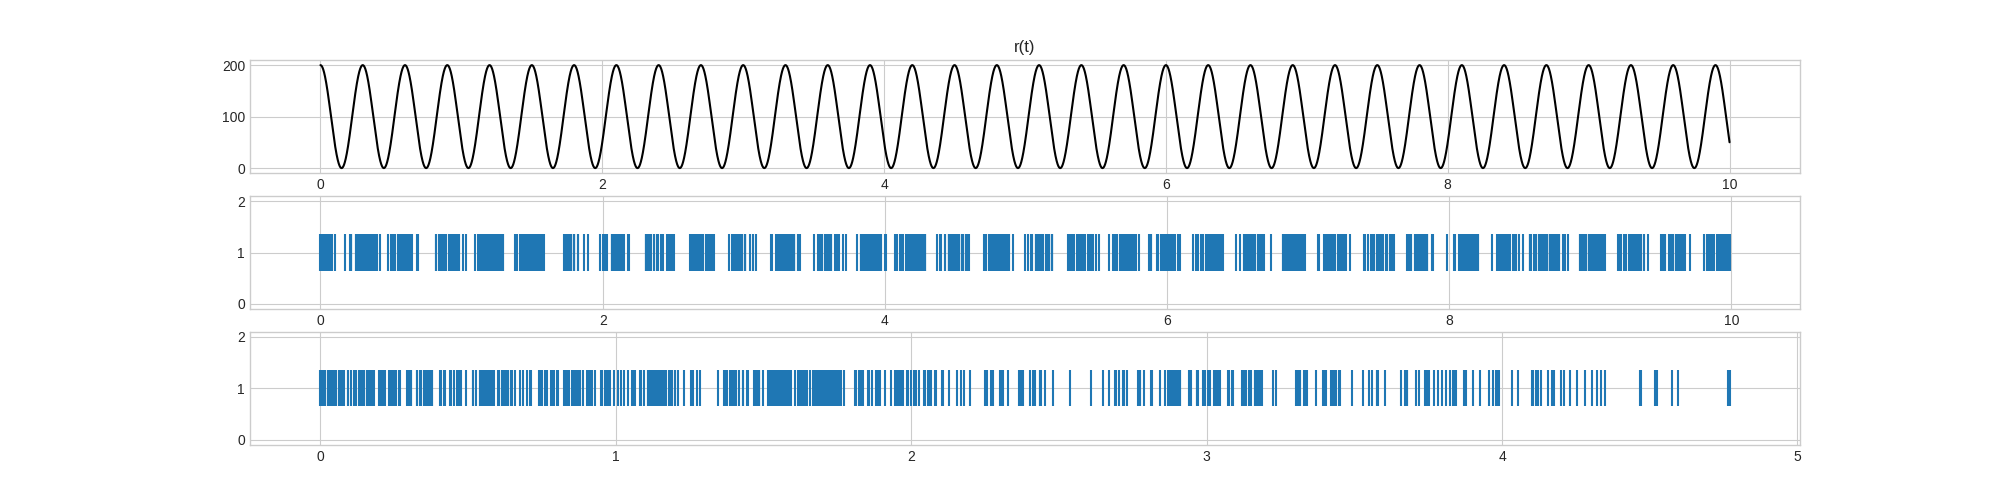

In [122]:
fig, axs = plt.subplots(3, 1, figsize=(20, 5));
time = np.arange(0, 10, 1e-4)

axs[0].plot(time, r(time), color='black');
axs[0].set_title('r(t)')

axs[1].eventplot(spikes, linelength=0.7);

axs[2].eventplot(spikes2, linelength=0.7);